In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

In [2]:
df = pd.read_pickle("Data_allnum.pkl")

### Początkowe zestawienia

Zaczniemy od spojrzenia na dane przed przeprowadzeniem na nich działań. Pierwszym krokiem jest sprawdzenie, w których miastach jest największa ilość odejść klientów

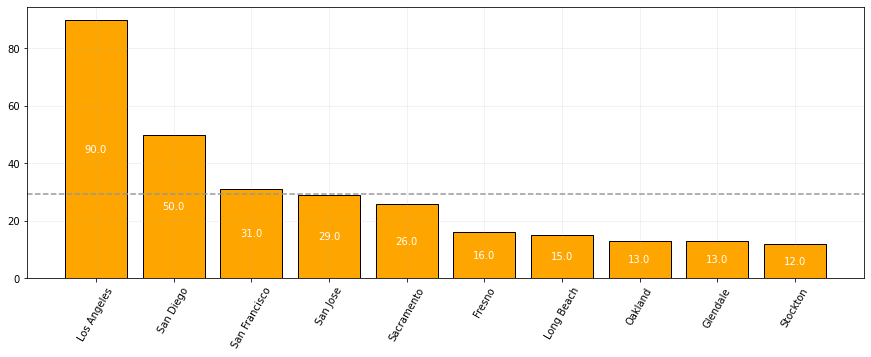

In [3]:
city_churn = df.groupby('City')['Churn Value'].agg(['sum', 'size'])
city_churn = city_churn[city_churn != 0].sort_values(by='sum', ascending=False)

X = city_churn.head(10).index
y = city_churn['sum'].head(10).values

plt.figure(figsize=(15,5))
slupki = plt.bar(np.arange(0, 10), y, color='orange', edgecolor="black")
plt.xticks(np.arange(0, 10), X, rotation=60)
plt.axhline(np.mean(y), ls='--', color='#999999')
plt.grid(alpha=0.2)

plt.bar_label(slupki, y, label_type='center', color="#ffffff")

plt.show()

Na wykresie zostało pokazane 10 miast z największą ilością odejść klientów. Aby lepiej zrozumieć dane dostawimy do nich sume ilości badanych osób w miastach oraz stosunek badań do odejść. Dzięki temu będzimy mogli zobaczyć, w którym mieście jest największy stosunek odejść klientów.

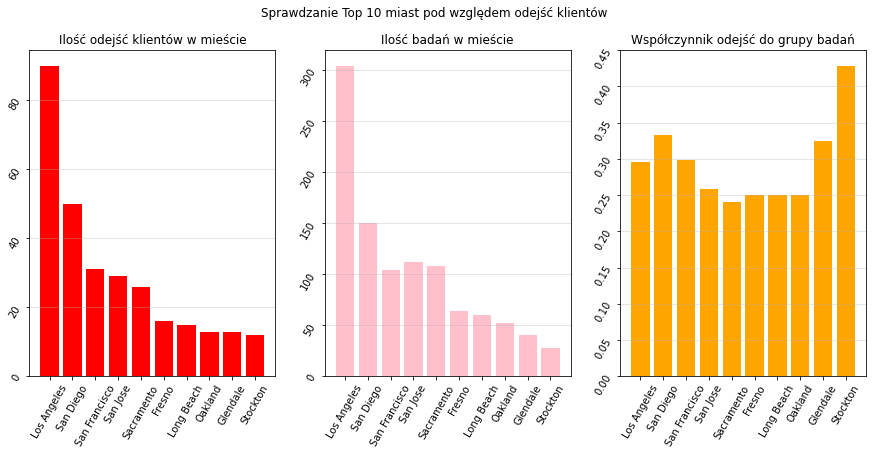

In [4]:
city_churn['comp'] = city_churn['sum'] / city_churn['size']
city_churn = city_churn[city_churn != 0].sort_values(by='sum', ascending=False)
y_churn = city_churn['sum'].head(10).values
y_size = city_churn['size'].head(10).values
y_comp = city_churn['comp'].head(10).values

fig, ax = plt.subplots(1, 3, figsize=(15,6))

ax[0].bar(X, y_churn, color="red")
ax[0].set_title("Ilość odejść klientów w mieście")

ax[1].bar(X, y_size, color="pink")
ax[1].set_title("Ilość badań w mieście")

ax[2].bar(X, y_comp, color="orange")
ax[2].set_title("Współczynnik odejść do grupy badań")

for bar in ax:
    bar.tick_params(labelrotation=60)
    bar.grid(True, axis="y", alpha=0.4)
    
fig.suptitle("Sprawdzanie Top 10 miast pod względem odejść klientów")

plt.show()

Możemy zobaczyć, że `Stockton` ma nawiększą ilość odejść w stosunku do badanych danych. Można również spojrzeć na `San Diego`, 
ma on o wiele większą ilość danych oraz drugi z kolei współczynnik odejść.

### Podział na zbiory

Aby dokładniej przeewaluować model zbiór zostanie podzielony na uczący i testowy w stosunku 80:20

In [5]:
X = df.drop(['City', 'Churn Value', 'Churn Score', 'CLTV'], axis=1).values
y = df['Churn Value'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Regresja logistyczna

Modele zostaną zbudowane za pomocą `pipeline`, który pozwala łączyć kilka czynności w jedną całość. W pierwszej kolejności zostanie użyta regresja logistyczna, która jest praktycznie stworzona dla problemów klasyfikacyjnych. Zostanie użyta na danych po skalowaniu oraz jej wartości zostaną zoptymalizowane za pomocą `GridSearchCV`. Do schowania powiadomień o błędnym dopasowaniu parametrów przy GridSearchCV użyty zostanie modół `warnings`, którego uzywa `sklearn` do pokazywania ostrzeżeń

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import warnings

In [7]:
logreg = LogisticRegression()

param_grid = {"solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             "penalty": ['l1', 'l2', 'elasticnet', 'none'],
             "C": [0.2, 0.5, 1, 2, 3, 5]}

warnings.filterwarnings('ignore')
cv = GridSearchCV(logreg, param_grid=param_grid, cv=5)
cv.fit(X_train, y_train)

logreg.fit(X_train, y_train)

y_pred = cv.predict(X_test)

print(f"Najlepsze parametry regresji: {cv.best_params_}")
print(f"Najlepsze accuracy regresji: {cv.best_score_}")
print(f"Predykcja z najlepszego modelu {cv.score(X_test, y_test)} \n")

print(f"Predykcja na niedostosowanym modelu Logistic Regression {logreg.score(X_test, y_test)}")

print(classification_report(y_test, y_pred, target_names=["0", "1"]))

y_pred_proba = cv.predict_proba(X_test)[:,1]
fprlog, tprlog, thresholdlog = roc_curve(y_test, y_pred_proba)

Najlepsze parametry regresji: {'C': 0.2, 'penalty': 'l2', 'solver': 'newton-cg'}
Najlepsze accuracy regresji: 0.8051555555555556
Predykcja z najlepszego modelu 0.8258706467661692 

Predykcja na niedostosowanym modelu Logistic Regression 0.8351101634683724
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1030
           1       0.70      0.60      0.65       377

    accuracy                           0.83      1407
   macro avg       0.78      0.76      0.77      1407
weighted avg       0.82      0.83      0.82      1407



W tym przykładzie dostosowanie parametrów nie wprowadziło istotnej różnicy i proces jest lepszy o około 0,05pp. Natomiast model osiągnął dokładność na poziomie 80%

### Drzewo decyzyjne

Kolejnym modelem, który zostanie wybrany do testowania predykcji danych jest `Decision Tree`. Tak jak w poprzednim modelu za pomocą `GridSearchCV` zostaną dostosowane parametry modelu. W modelu nie zostanie wykonane skalowanie ponieważ nie jest on wrażliwy na wariancje.

In [8]:
from sklearn.tree import DecisionTreeClassifier

In [9]:
tree = DecisionTreeClassifier()

param_grid = {'criterion': ['gini', 'entropy'],
             'max_depth': [2, 3, 5, 7, 10],
             'min_samples_split': [4, 6, 8, 12, 15],
             'min_samples_leaf': [3, 4, 5, 8, 10]}
cv = GridSearchCV(tree, param_grid=param_grid, cv=5)

warnings.filterwarnings('ignore')
cv.fit(X_train, y_train)
tree.fit(X_train, y_train)

y_pred = cv.predict(X_test)

print(f"Najlepsze parametry regresji: {cv.best_params_}")
print(f"Najlepsze accuracy regresji: {cv.best_score_}")
print(f"Predykcja z najlepszego modelu {cv.score(X_test, y_test)} \n")

print(f"Predykcja na niedostosowanym modelu drzewa decyzyjnego {tree.score(X_test, y_test)}")

print("Raport z klasyfikacji dla modelu \n")
print(classification_report(y_test, y_pred, target_names=["0", "1"]))

y_pred_proba = cv.predict_proba(X_test)[:,1]
fprtree, tprtree, thresholdtree = roc_curve(y_test, y_pred_proba)

Najlepsze parametry regresji: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 4}
Najlepsze accuracy regresji: 0.7880888888888891
Predykcja z najlepszego modelu 0.8031272210376688 

Predykcja na niedostosowanym modelu drzewa decyzyjnego 0.7249466950959488
Raport z klasyfikacji dla modelu 

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1030
           1       0.67      0.53      0.59       377

    accuracy                           0.80      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.79      0.80      0.80      1407



### KNN
Ostatnim modelem, który przerobimy jest KNN z dostosowaniem parametrów i skalowaniem wartości w pipeline.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 

In [11]:
knn = KNeighborsClassifier()
scaler = StandardScaler()

steps = [("scaler", scaler),
         ("knn", knn)]
pipeline = Pipeline(steps)

param_grid = {"knn__n_neighbors": [4, 6, 8, 12, 20],
             "knn__algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
             "knn__leaf_size": [30, 35, 40, 50]}
cv = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
cv.fit(X_train, y_train)

knn.fit(X_train, y_train)

y_pred = cv.predict(X_test)

print(f"Najlepsze parametry regresji: {cv.best_params_}")
print(f"Najlepsze accuracy regresji: {cv.best_score_}")
print(f"Predykcja z najlepszego modelu {cv.score(X_test, y_test)} \n")

print(f"Predykcja na niedostosowanym modelu K-nearest neighbors: {knn.score(X_test, y_test)}")

print(classification_report(y_test, y_pred, target_names=["0", "1"]))

y_pred_proba = cv.predict_proba(X_test)[:,1]
fprknn, tprknn, thresholdtree = roc_curve(y_test, y_pred_proba)

Najlepsze parametry regresji: {'knn__algorithm': 'ball_tree', 'knn__leaf_size': 30, 'knn__n_neighbors': 20}
Najlepsze accuracy regresji: 0.7896888888888889
Predykcja z najlepszego modelu 0.8130774697938877 

Predykcja na niedostosowanym modelu K-nearest neighbors: 0.767590618336887
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1030
           1       0.69      0.56      0.61       377

    accuracy                           0.81      1407
   macro avg       0.77      0.73      0.75      1407
weighted avg       0.80      0.81      0.81      1407



### Krzywe ROC modeli

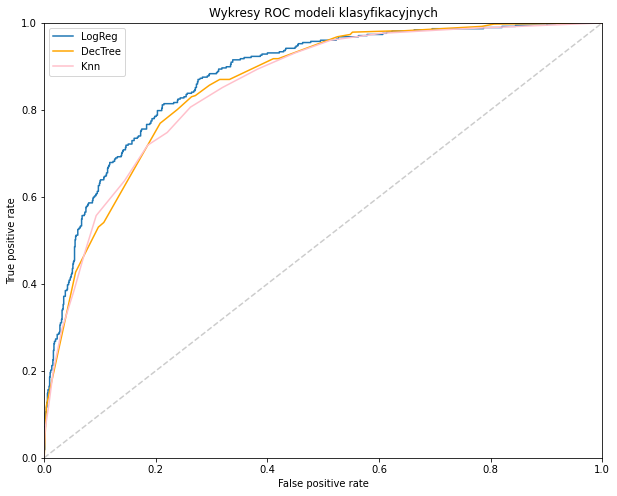

In [23]:
plt.figure(figsize=(10,8))

plt.plot(fprlog, tprlog, label="LogReg")
plt.plot(fprtree,tprtree, label="DecTree", color="orange")
plt.plot(fprknn, tprknn, label="Knn", color="pink")

plt.legend()

plt.axline((0,0), (1,1), color='gray', alpha=0.4, ls='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Wykresy ROC modeli klasyfikacyjnych")

plt.show()